In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import os
import sys

# Ensure src is discoverable
sys.path.append(os.path.abspath(".."))

from src.finance_utils import load_price_data


In [6]:

# Load News Data
news = pd.read_csv("../data/raw_analyst_ratings.csv")
print(news.columns)  # Confirm column names

news['date'] = pd.to_datetime(news['date'], errors='coerce')
print(news['date'].head())  # Confirm conversion worked

# Extract just the date (drop time component)
news['date'] = news['date'].dt.date

# Sentiment Function
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply Sentiment
news['sentiment'] = news['headline'].apply(get_sentiment)


Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')
0   2020-06-05 10:30:54-04:00
1   2020-06-03 10:45:20-04:00
2   2020-05-26 04:30:07-04:00
3   2020-05-22 12:45:06-04:00
4   2020-05-22 11:38:59-04:00
Name: date, dtype: datetime64[ns, UTC-04:00]


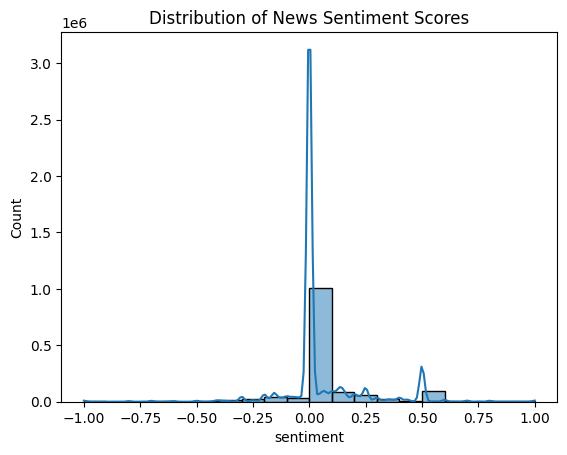

In [7]:

# Check Sentiment Distribution
sns.histplot(news['sentiment'], bins=20, kde=True)
plt.title("Distribution of News Sentiment Scores")
plt.show()



Processing AAPL...


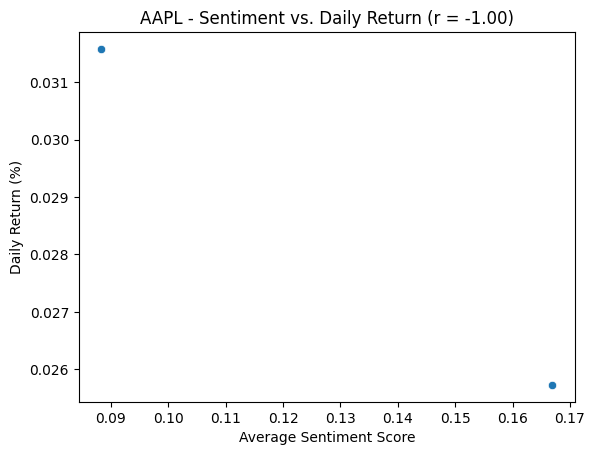


Processing AMZN...


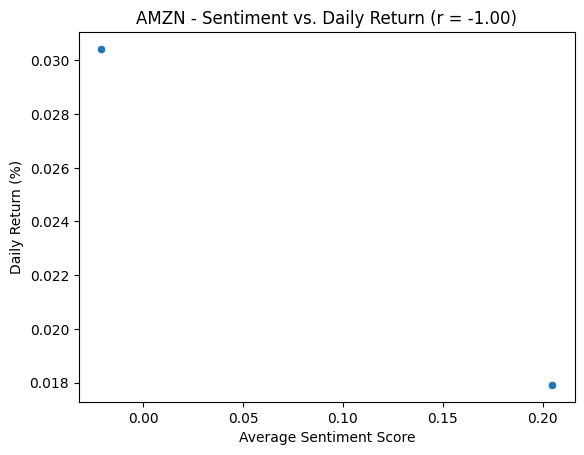


Processing GOOG...


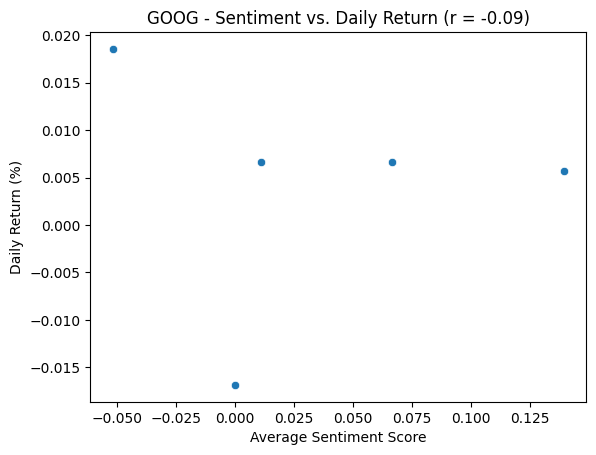


Processing META...


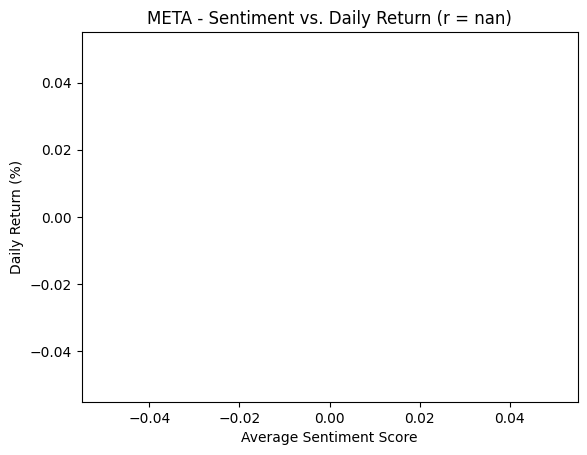


Processing MSFT...


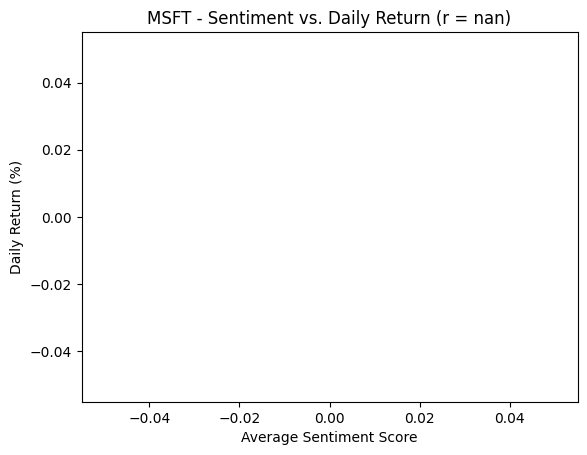


Processing NVDA...


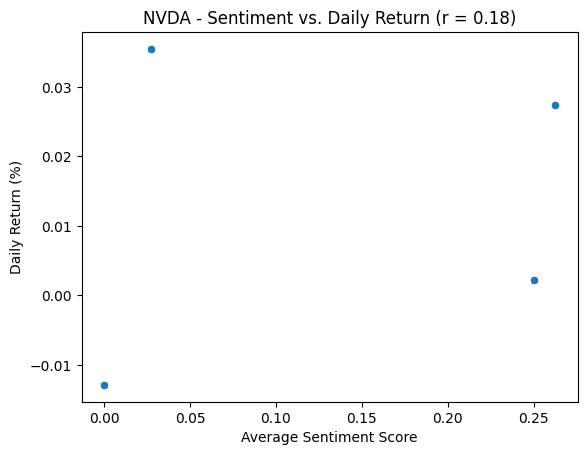


Processing TSLA...


c:\cha\personal\10Academy\predicting_price_moves_with_news_sentiment-week1\venv310\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\cha\personal\10Academy\predicting_price_moves_with_news_sentiment-week1\venv310\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\cha\personal\10Academy\predicting_price_moves_with_news_sentiment-week1\venv310\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


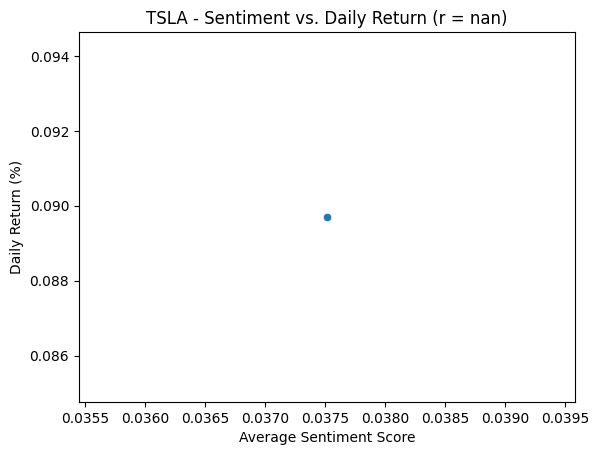


=== Correlation Summary ===
  Stock  Correlation
0  AAPL    -1.000000
1  AMZN    -1.000000
2  GOOG    -0.089449
3  META          NaN
4  MSFT          NaN
5  NVDA     0.175714
6  TSLA          NaN


In [8]:

# File Mapping
stock_files = {
    "AAPL": "../data/yfinance_data/AAPL_historical_data.csv",
    "AMZN": "../data/yfinance_data/AMZN_historical_data.csv",
    "GOOG": "../data/yfinance_data/GOOG_historical_data.csv",
    "META": "../data/yfinance_data/META_historical_data.csv",
    "MSFT": "../data/yfinance_data/MSFT_historical_data.csv",
    "NVDA": "../data/yfinance_data/NVDA_historical_data.csv",
    "TSLA": "../data/yfinance_data/TSLA_historical_data.csv"
}

# Store correlation results
results = []

# Iterate over each stock
for symbol, filepath in stock_files.items():
    print(f"\nProcessing {symbol}...")
    
    # Load Stock Data
    df = load_price_data(filepath)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df['daily_return'] = df['Close'].pct_change()
    
    # Filter News for that stock
    stock_news = news[news['stock'] == symbol]
    
    # Aggregate Daily Sentiment
    daily_sentiment = stock_news.groupby('date')['sentiment'].mean().reset_index()
    daily_sentiment.rename(columns={'date': 'Date', 'sentiment': 'avg_sentiment'}, inplace=True)
    
    # Merge
    merged = pd.merge(df, daily_sentiment, on='Date', how='left')
    
    # Drop NaNs for analysis
    merged_clean = merged.dropna(subset=['avg_sentiment', 'daily_return'])
    
    # Correlation
    corr = merged_clean['avg_sentiment'].corr(merged_clean['daily_return'])
    results.append({"Stock": symbol, "Correlation": corr})
    
    # Scatter Plot
    sns.scatterplot(data=merged_clean, x='avg_sentiment', y='daily_return')
    plt.title(f'{symbol} - Sentiment vs. Daily Return (r = {corr:.2f})')
    plt.xlabel("Average Sentiment Score")
    plt.ylabel("Daily Return (%)")
    plt.show()
    
# Summary Table
results_df = pd.DataFrame(results)
print("\n=== Correlation Summary ===")
print(results_df)
